In [1]:
#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import preprocessing
import matplotlib.cm as cm
plt.style.use('seaborn')

In [2]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')
orders = pd.read_csv('data/orders.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [3]:
#Downsampling
n_samples = 150000
ids_ = order_products.order_id.unique().tolist()
id_selected = random.sample(ids_,n_samples)
order_products_sr = order_products[order_products.order_id.isin(id_selected)]

In [4]:
pbu1 = order_products_sr.merge(products, on = 'product_id').sort_values(by = ['order_id','add_to_cart_order'])
pbu = pbu1.loc[:,['order_id','product_name']]
print(f'Rows: {pbu.shape[0]}')
pbu['product_name'] = pbu.product_name.str.strip().str.lower()#.str.split(' ')
pbu.head()
#creating an index of stop words to remove some words 

Rows: 1512633


,order_id,product_name
0,8,original hawaiian sweet rolls
123,63,wild blend rice
205,63,reduced-fat soft cream cheese
292,63,garlic powder
597,63,whole grain oatmeal bread


In [5]:
%%time
id_list = pbu.order_id.unique()
prods = [pbu.product_name[pbu.order_id == x].to_list() for x in id_list]
listed_products = pd.DataFrame(list(zip(id_list,prods)),columns = ['order_id','products'])

Wall time: 10min 33s


In [6]:
print(f'Rows: {listed_products.shape[0]}')
listed_products.order_id = listed_products.order_id.astype(str)
listed_products.head()

Rows: 150000


,order_id,products
0,8,[original hawaiian sweet rolls]
1,63,"[wild blend rice, reduced-fat soft cream chees..."
2,65,"[organic 1% lowfat milk, organic 2% reduced fa..."
3,90,"[organic baby carrots, crescent rolls, organic..."
4,110,"[organic lemon, organic unsweetened almond mil..."


In [7]:
%%time
#training model
tagged_products = listed_products.values.tolist()
products_by_user = [TaggedDocument(products, [order_id]) for order_id, products in tagged_products]

d2v_model = Doc2Vec(documents   = products_by_user,
                    vector_size = 30,
                    min_count   = 100,
                    workers     = 4
                   )

# comparing similarity
sample_ = str(id_selected[0])
return_3 = d2v_model.docvecs.most_similar([d2v_model[sample_]])[:4]
print(return_3)
# look into word2Vec what if the user first buys a bag of lemons what are the following recommendations

[('1138239', 1.0), ('1762187', 0.9199771881103516), ('611160', 0.9196829795837402), ('2948925', 0.9165582656860352)]
Wall time: 1min 44s


In [8]:
pbu1 = pbu1[['order_id','product_name']]
sample  = pbu1[pbu1.order_id == int(return_3[0][0])]
compare1 = pbu1[pbu1.order_id == int(return_3[1][0])]
compare2 = pbu1[pbu1.order_id == int(return_3[2][0])]

print('NUMBER OF ITEMS',
    '\nSample products: ',len(sample),
      '\nCompare products 1: ',len(compare1),
      '\nCompare products 2: ',len(compare2))

comp = sample.merge(compare1, on = 'product_name', how = 'outer')
comp = comp.merge(compare2, on = 'product_name', how = 'outer')
comp[['order_id_x','order_id_y','order_id','product_name']]

NUMBER OF ITEMS 
Sample products:  7 
Compare products 1:  10 
Compare products 2:  4


,order_id_x,order_id_y,order_id,product_name
0,1138239.0,NaN,NaN,Balsamic Vinegar Of Modena
1,1138239.0,NaN,NaN,Organic Cotton Balls
2,1138239.0,NaN,NaN,Yellow Onions
3,1138239.0,NaN,NaN,Red Peppers
4,1138239.0,NaN,NaN,Toasted Coconut Chips Original Recipe
5,1138239.0,NaN,NaN,Sweet Potatoes
6,1138239.0,NaN,NaN,Organic Coconut Date Rolls
7,NaN,1762187.0,NaN,Chunky Peanut Butter
8,NaN,1762187.0,NaN,Super Soft Flour Tortillas Fajita Size 20 ct
9,NaN,1762187.0,NaN,Honeycrisp Apple


## Elbow plot

In [9]:
%%time
distorsions = []
clusters = list(range(1,11))
for k in clusters:
    kmeans = KMeans(n_clusters= k, init='k-means++', max_iter=100)
    kmeans.fit(d2v_model.docvecs.vectors_docs)
    distorsions.append(kmeans.inertia_)

Wall time: 2min 25s


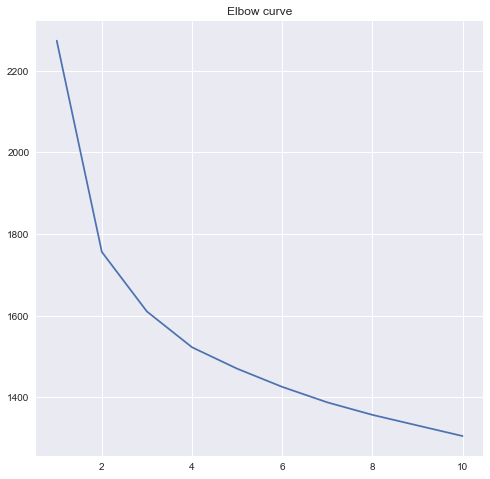

In [10]:
fig = plt.figure(figsize=(8, 8))
plt.plot(clusters, distorsions)
plt.title('Elbow curve')
plt.show()

## Clustering

In [11]:
n_clusters_ = 3
#normalize docVecs before OR use cosine distance for KMeans
#Use DocVecs as features in stacking !!
kmeans_model = KMeans(n_clusters=n_clusters_, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
cluster_labels = kmeans_model.labels_
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

## Representing groups

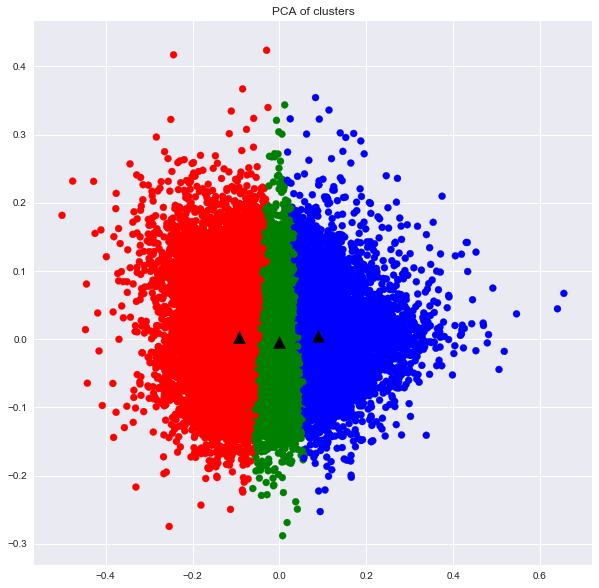

In [12]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in cluster_labels.tolist()]
plt.scatter(datapoint[:, 0], datapoint[:, 1],c = color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

## Silhouette analysis

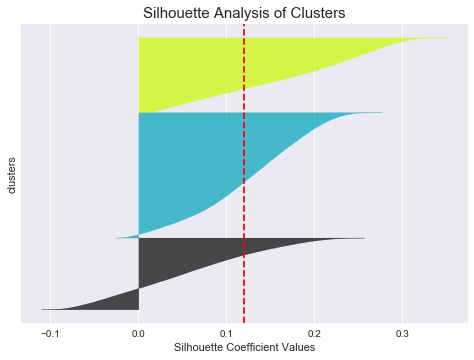

Wall time: 21min 35s


In [13]:
%%time
sample_silhouette_values = silhouette_samples(d2v_model.docvecs.vectors_docs, cluster_labels, metric='euclidean')

y_lower = 10

for i in range(n_clusters_):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    color = cm.nipy_spectral(float(i) / n_clusters_)
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color,edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10
    
silhouette_avg  = silhouette_score(d2v_model.docvecs.vectors_docs, cluster_labels)
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Analysis of Clusters', fontsize = 15)
plt.ylabel('clusters')
plt.yticks([])
plt.xlabel('Silhouette Coefficient Values')
plt.show()

# Analyzing clusters

In [14]:
listed_products['group'] = cluster_labels
listed_products.order_id = listed_products.order_id.astype(int)
lp_expanded = listed_products.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

,order_id,products,group,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,8,[original hawaiian sweet rolls],2,23423,1,1,Original Hawaiian Sweet Rolls,43,3
1,12260,"[organic variety pack, cherrios honey nut, ori...",1,23423,3,1,Original Hawaiian Sweet Rolls,43,3
2,64266,"[spinach artichoke dip, organic simply naked p...",1,23423,3,0,Original Hawaiian Sweet Rolls,43,3
3,122901,"[apples, peaches, crispy chicken strips, zero ...",0,23423,5,1,Original Hawaiian Sweet Rolls,43,3
4,129958,[imported sardines in pure olive oil skinless ...,0,23423,4,0,Original Hawaiian Sweet Rolls,43,3


## cart size by group

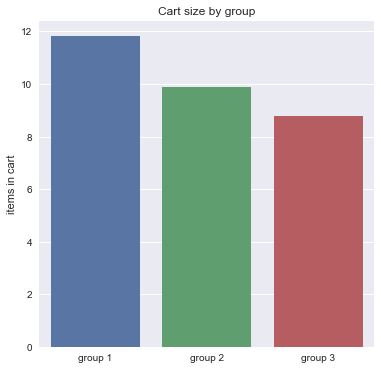

In [15]:
avg_cart_size_g1 = group_1.groupby('order_id').count().mean()[0]
avg_cart_size_g2 = group_2.groupby('order_id').count().mean()[0]
avg_cart_size_g3 = group_3.groupby('order_id').count().mean()[0]
avg_carts = [avg_cart_size_g1,avg_cart_size_g2,avg_cart_size_g3]

fig = plt.figure(figsize=(6, 6))
sns.barplot(x = ['group 1','group 2','group 3'],
            y = avg_carts)
plt.title('Cart size by group')
plt.ylabel('items in cart')
plt.show()

## Top departments for each group

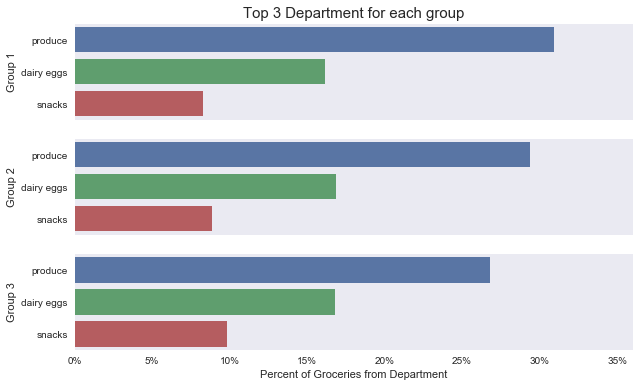

In [16]:
#group 1
t3_dept_g1_count = group_1.department_id.value_counts()[:3]/len(group_1.aisle_id)
t3_dept_g1 = departments[departments.department_id.isin(t3_dept_g1_count.index.to_list())].department

#group 2
t3_dept_g2_count = group_2.department_id.value_counts()[:3]/len(group_2.aisle_id)
t3_dept_g2 = departments[departments.department_id.isin(t3_dept_g2_count.index.to_list())].department

#group 3
t3_dept_g3_count = group_3.department_id.value_counts()[:3]/len(group_3.aisle_id)
t3_dept_g3 = departments[departments.department_id.isin(t3_dept_g3_count.index.to_list())].department

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.36
#group 1
plt.subplot(311)
plt.title('Top 3 Department for each group', fontsize = 15)
g1 = sns.barplot(x = t3_dept_g1_count.tolist(), y = t3_dept_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_dept_g2_count.tolist(), y = t3_dept_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_dept_g3_count.tolist(), y = t3_dept_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Department')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## Top Aisles for each group

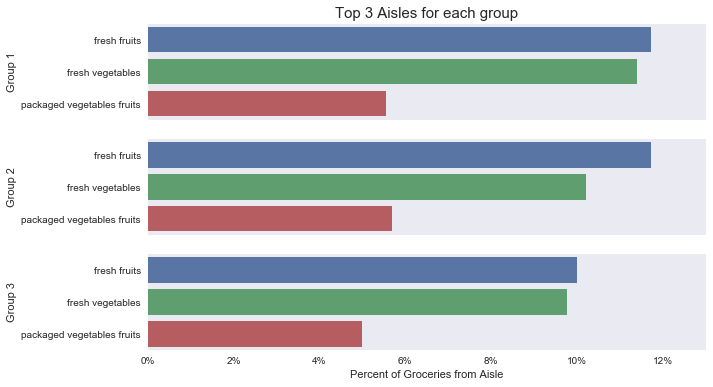

In [17]:
#group 1
t3_aisles_g1_count = group_1.aisle_id.value_counts()[:3]/len(group_1.aisle_id)
t3_aisles_g1 = aisles[aisles.aisle_id.isin(t3_aisles_g1_count.index.to_list())].aisle

#group 2
t3_aisles_g2_count = group_2.aisle_id.value_counts()[:3]/len(group_2.aisle_id)
t3_aisles_g2 = aisles[aisles.aisle_id.isin(t3_aisles_g2_count.index.to_list())].aisle

#group 3
t3_aisles_g3_count = group_3.aisle_id.value_counts()[:3]/len(group_3.aisle_id)
t3_aisles_g3 = aisles[aisles.aisle_id.isin(t3_aisles_g3_count.index.to_list())].aisle

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.13
#group 1
plt.subplot(311)
plt.title('Top 3 Aisles for each group', fontsize = 15)
g1 = sns.barplot(x = t3_aisles_g1_count.tolist(), y = t3_aisles_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_aisles_g2_count.tolist(), y = t3_aisles_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_aisles_g3_count.tolist(), y = t3_aisles_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Aisle')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## top products in each cluster

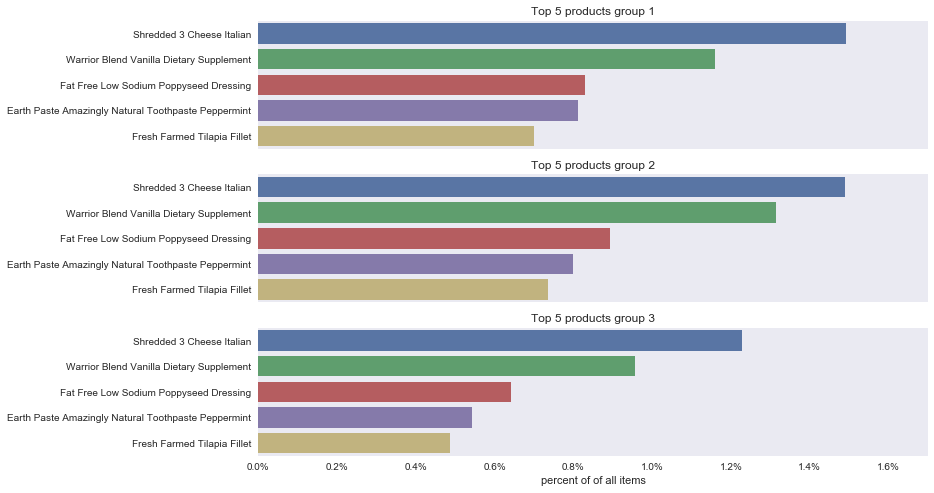

In [18]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---

## Word Vector Analysis

In [19]:
selected_ = pbu[pbu.order_id == int(tagged_products[0][0])]
selected_.head()

,order_id,product_name
0,8,original hawaiian sweet rolls


In [20]:
for pn in selected_.product_name:
    try:
        print('\nSelected Word: ',pn,
              '\nWord2Vec similar words: \n',
              d2v_model.wv.most_similar(pn)[0][0],
              '\n',
              d2v_model.wv.most_similar(pn)[1][0],
              '\n',
              d2v_model.wv.most_similar(pn)[2][0]
             )
    except Exception as e:
        print('\n\n')
        print(f'word {pn} did not meet minimum threshold')
          


Selected Word:  original hawaiian sweet rolls 
Word2Vec similar words: 
 organic variety pack 
 unsweetened vanilla almond breeze 
 sea salt brown rice crackers


In [21]:
d2v_model.wv.most_similar('yellow onions')

[('white onion', 0.8003034591674805),
 ('sweet onions', 0.778810977935791),
 ('organic yellow onion', 0.7607359290122986),
 ('dressing, jersey sweet onion, calorie free', 0.7595760822296143),
 ('fresh basil', 0.7593936920166016),
 ('california cauliflower', 0.7536523342132568),
 ('boneless skinless chicken thighs', 0.7393239736557007),
 ('shallot', 0.7297982573509216),
 ('pork chorizo', 0.7283297777175903),
 ('poblano pepper', 0.7282788157463074)]

In [22]:
d2v_model.wv.most_similar('yellow bell pepper')

[('orange bell pepper', 0.9262107610702515),
 ('organic bell pepper', 0.822433590888977),
 ('organic cherry tomatoes', 0.8214300870895386),
 ('green bell pepper', 0.8209075927734375),
 ('red onion', 0.7875049114227295),
 ('red peppers', 0.7744238376617432),
 ('european cucumber', 0.7731682062149048),
 ('asparagus', 0.7626112103462219),
 ('ground turkey breast', 0.7579585909843445),
 ('organic grape tomatoes', 0.7493996620178223)]

In [23]:
d2v_model.wv.most_similar('green beans')

[('sliced white mushrooms', 0.9340758323669434),
 ('large greenhouse tomato', 0.9207537770271301),
 ('microwave in bag green beans', 0.9188246726989746),
 ('broccoli crown', 0.9069924354553223),
 ('yellow straightneck squash', 0.9063091278076172),
 ('romaine lettuce', 0.8976718783378601),
 ('english seedless cucumber', 0.8957106471061707),
 ('asparation/broccolini/baby broccoli', 0.8911277055740356),
 ('fancy eggplant', 0.8898118734359741),
 ('russet potato', 0.8894787430763245)]

---

## Stacking with the vectorized model

In [24]:
vecs_df = pd.DataFrame(d2v_model.docvecs.vectors_docs)
vecs_df.columns = ['vec_' + str(col+1) for col in vecs_df.columns]
vecs_df['order_id'] = listed_products.order_id

orders = orders[['order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
stacked_df = orders.merge(vecs_df,on = 'order_id')
stacked_df = stacked_df.drop('order_id',axis = 1)
print(f'Number of rows: {stacked_df.shape[0]} \nnumber of columns: {stacked_df.shape[1]}')
stacked_df.days_since_prior_order = stacked_df.days_since_prior_order.fillna(0)
stacked_df.head()

Number of rows: 150000 
number of columns: 34


,order_number,order_dow,order_hour_of_day,days_since_prior_order,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,...,vec_21,vec_22,vec_23,vec_24,vec_25,vec_26,vec_27,vec_28,vec_29,vec_30
0,4,3,15,14.0,0.014303,0.028985,-0.035268,0.033409,0.030256,0.005364,...,0.033381,-0.013342,-0.038940,0.002825,0.013136,0.043276,-0.002879,-0.067627,0.027350,-0.014241
1,9,2,13,7.0,-0.014628,-0.038064,-0.007626,0.037832,0.015923,-0.008534,...,0.035961,-0.017428,-0.030807,-0.009212,0.044176,-0.006876,-0.009335,0.008296,-0.034732,0.004694
2,3,1,13,7.0,0.000419,-0.025819,0.036999,-0.000443,0.018626,-0.025169,...,0.012156,-0.032310,0.003706,-0.010262,0.010371,0.016427,-0.019781,0.016033,-0.023038,-0.009238
3,20,1,10,12.0,0.000576,-0.032068,0.035264,-0.005385,-0.010987,0.005915,...,0.015049,-0.026051,0.007557,-0.033603,0.053406,0.015604,0.020342,0.009456,-0.032805,0.005671
4,28,1,9,5.0,-0.001828,-0.031623,0.022844,0.042355,0.007902,-0.018703,...,0.036367,-0.017806,-0.004394,0.002649,0.045786,0.002011,0.022469,0.006321,-0.051099,-0.034712


In [25]:
stacked_df = pd.DataFrame(preprocessing.scale(vecs_df))
stacked_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.199743,-0.771612,0.301795,0.895350,0.002192,-1.085211,-0.151705,-0.216545,-1.628355,1.089614,...,-0.595529,-0.907675,0.034998,0.948653,-0.418917,-0.056361,-0.337028,-1.009372,0.081786,-1.731348
1,-0.681462,-0.499419,-0.434082,-0.594453,-1.359808,0.592078,0.249577,1.284146,-0.482055,-1.028834,...,-0.900371,0.334825,1.366633,0.358187,-0.111065,1.317062,-0.091649,-0.002958,0.096987,-1.731292
2,-0.845758,-0.734370,0.015919,0.585125,-0.370472,-0.647982,-0.184216,0.099519,-1.337468,0.086082,...,-0.225042,-0.713329,0.712271,1.345133,1.270313,-0.754737,-0.592313,-0.799317,-0.172543,-1.731290
3,-0.604050,-1.527318,0.936973,1.565011,0.859311,-0.159852,-0.672028,-1.609649,-1.458804,1.268595,...,-1.645971,-1.197659,0.571734,1.310766,-0.449798,-0.995905,-1.377913,-2.417616,-1.471275,-1.731265
4,-1.056780,0.278019,0.513091,-0.221497,-0.402581,0.215710,0.689064,0.284056,-0.213257,-0.632623,...,0.812924,-0.556576,0.534297,-0.957337,0.112522,-0.274338,-0.774921,-0.144847,0.802886,-1.731245


In [26]:
cluster_num = 2000
kmeans_stacking = KMeans(n_clusters=cluster_num, init='k-means++', max_iter=100) 
X_stacked = kmeans_stacking.fit(X = stacked_df)
stacked_cluster_labels = kmeans_stacking.labels_
pca = PCA(n_components=2).fit(stacked_df)
stacked_datapoint = pca.transform(stacked_df)

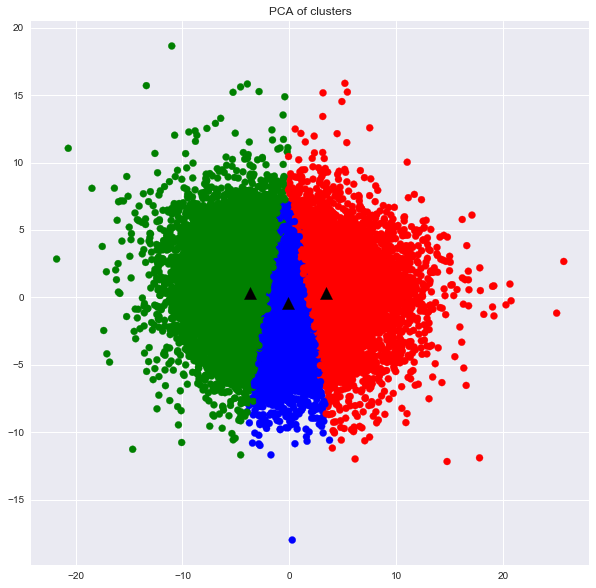

In [27]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in stacked_cluster_labels.tolist()]
plt.scatter(stacked_datapoint[:, 0], stacked_datapoint[:, 1],c = color)
centroids = kmeans_stacking.cluster_centers_
stacked_centroidpoint = pca.transform(centroids)
plt.scatter(stacked_centroidpoint[:, 0], stacked_centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

In [28]:
listed_products['group'] = stacked_cluster_labels
listed_products.order_id = listed_products.order_id.astype(int)
lp_expanded = listed_products.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

,order_id,products,group,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,8,[original hawaiian sweet rolls],0,23423,1,1,Original Hawaiian Sweet Rolls,43,3
1,12260,"[organic variety pack, cherrios honey nut, ori...",2,23423,3,1,Original Hawaiian Sweet Rolls,43,3
2,64266,"[spinach artichoke dip, organic simply naked p...",2,23423,3,0,Original Hawaiian Sweet Rolls,43,3
3,122901,"[apples, peaches, crispy chicken strips, zero ...",1,23423,5,1,Original Hawaiian Sweet Rolls,43,3
4,129958,[imported sardines in pure olive oil skinless ...,1,23423,4,0,Original Hawaiian Sweet Rolls,43,3


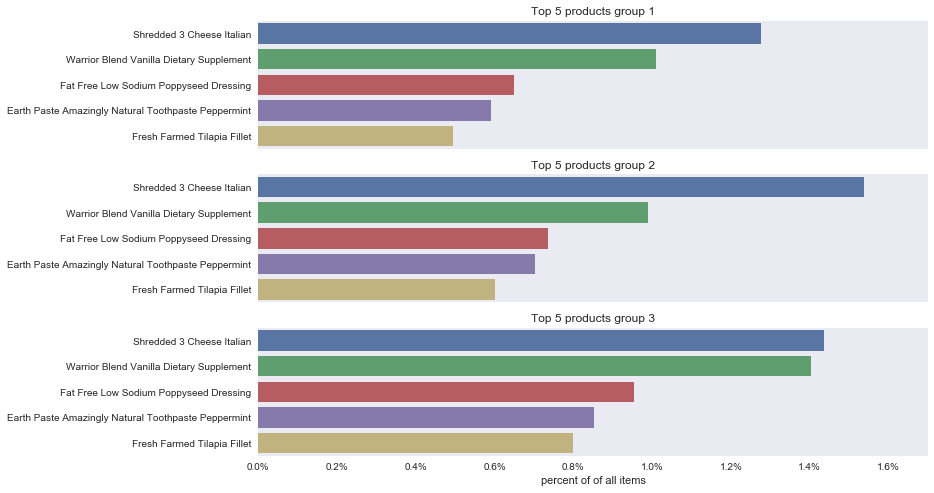

In [29]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---